# Generate Figures for Word2Vec Year Models

The goal of this notebook is to observe how words are shifting through time since 2000. The caveat here is that words have to been present within all time periods in order to be present for this task. Ideally words to be examined so far are: 'expression', 'are', 'interleukin-18', '95%ci', and 'p53'.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import plotnine as p9
import tqdm
from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP

from biovectors_modules.plot_helper import (
    plot_local_global_distances,
    plot_token_timeline,
    plot_wordcloud_neighbors,
    plot_wordcloud_neighbors_gif,
)
from biovectors_modules.word2vec_analysis_helper import (
    generate_timeline,
    get_neighbors,
    project_token_timeline,
)

# Load Models to Observe Changes

## Load Aligned Word Vectors

In [2]:
aligned_models = pickle.load(
    open("output/aligned_word_vectors_2000_2020_replace.pkl", "rb")
)

In [3]:
year_comparison_dict = {
    "_".join(comparison_file.stem.split("_")[0:2]): (
        pd.read_csv(str(comparison_file), sep="\t")
    )
    for comparison_file in (list(Path("output/year_distances_2000_2020").rglob("*tsv")))
}
list(year_comparison_dict.keys())[0:3]

['2000_2018', '2000_2004', '2000_2013']

In [4]:
year_comparison_dict["2000_2005"].sort_values("global_dist", ascending=False)

,token,global_dist,local_dist,shift
9399,oldest,1.391098,1.897213,-0.506115
11767,scapularis,1.388002,1.549426,-0.161424
8922,myopathy,1.362899,1.525750,-0.162851
94,0.046,1.347910,1.558619,-0.210708
14191,xenotransplantation,1.310723,1.528180,-0.217457
...,...,...,...,...
13583,und,0.072687,0.002938,0.069749
4864,einer,0.069218,0.002453,0.066764
262,1.6,0.068344,0.001212,0.067132
2230,bei,0.067361,0.001780,0.065582


## Train UMAP Model to Project Time Shifts into Two Dimensional Space

The goal here is to train a TSNE model that projects all words from 2000 to 2020 into a two dimensional space. Allows one to visually track how a word vector is shifting through time.

In [5]:
word_models_stacked = np.vstack(list(aligned_models.values())[:-1])
file_name = "output/2000_2020_umap_model"

In [6]:
if not Path(file_name).exists():
    Path(file_name).mkdir(parents=True)
    model = ParametricUMAP(verbose=True, metric="cosine", random_state=100)
    embedding = model.fit_transform(word_models_stacked)
    model.save(file_name)
else:
    model = load_ParametricUMAP(file_name)
model.verbose = False

ParametricUMAP(optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fa4f1702048>)
Construct fuzzy simplicial set
Sat May  8 07:53:10 2021 Finding Nearest Neighbors
Sat May  8 07:53:10 2021 Building RP forest with 32 trees
Sat May  8 07:53:19 2021 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	Stopping threshold met -- exiting after 5 iterations
Sat May  8 07:53:42 2021 Finished Nearest Neighbor Search
Sat May  8 07:53:45 2021 Construct embedding


/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/umap/parametric_umap.py:270: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.


Epoch 1/10
4461/4461 [==============================] - 52s 11ms/step - loss: 0.2697
Epoch 2/10
4461/4461 [==============================] - 50s 11ms/step - loss: 0.1845
Epoch 3/10
4461/4461 [==============================] - 50s 11ms/step - loss: 0.1750
Epoch 4/10
4461/4461 [==============================] - 50s 11ms/step - loss: 0.1699
Epoch 5/10
4461/4461 [==============================] - 50s 11ms/step - loss: 0.1667
Epoch 6/10
4461/4461 [==============================] - 50s 11ms/step - loss: 0.1645
Epoch 7/10
4461/4461 [==============================] - 50s 11ms/step - loss: 0.1623
Epoch 8/10
4461/4461 [==============================] - 50s 11ms/step - loss: 0.1605
Epoch 9/10
4461/4461 [==============================] - 50s 11ms/step - loss: 0.1593
Epoch 10/10
9355/9355 [==============================] - 4s 409us/step
Sat May  8 08:02:43 2021 Finished embedding
INFO:tensorflow:Assets written to: output/2000_2020_umap_model/encoder/assets
Keras encoder model saved to output/2000_2

# Observe Diachronic Vector Changes

Global distance measures how far a word has moved within semantic space. This measure captures how words change globally across time periods. The greater the distance the more semantic change a word has been subjected towards.
The word clouds depict the neighbors for each word vector. The size for each token  appears to be different but size doesn't matter in this case. Each word has equal weighting.

## Are

In [7]:
token_timeline_df = generate_timeline(year_comparison_dict, "are")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
1803,are,0.235151,0.049797,0.185354,2000_2018
1803,are,0.146572,0.011491,0.135080,2000_2004
1803,are,0.251484,0.061038,0.190445,2000_2013
1803,are,0.236460,0.048854,0.187606,2000_2017
1803,are,0.021802,0.000495,0.021307,2000_2001


In [8]:
token_timeline_low_dim_df = project_token_timeline(
    "are", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,0.062957,-7.371141,2020,are,main
26,-0.089440,-7.531855,2019,are,main
52,-0.025730,-7.447204,2018,are,main
78,-0.044160,-7.482597,2017,are,main
104,-0.008154,-7.431612,2016,are,main
130,-0.003469,-7.418984,2015,are,main
156,0.036699,-7.387516,2014,are,main
182,-0.010986,-7.429005,2013,are,main
208,0.047305,-7.395699,2012,are,main
234,0.052403,-7.397871,2011,are,main


In [9]:
global_distance, local_distance = plot_local_global_distances(token_timeline_df, "are")

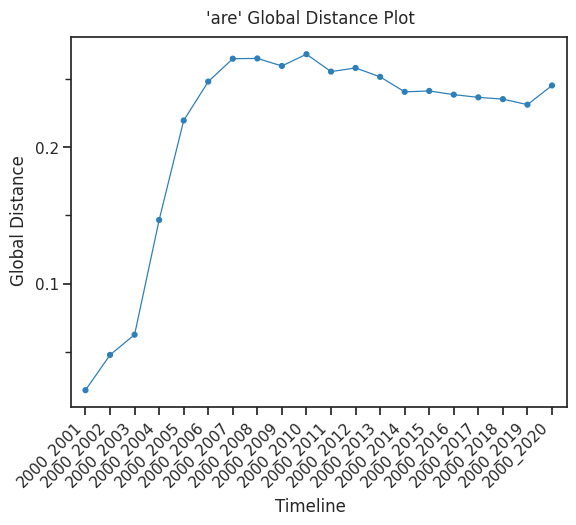

<ggplot: (8771739763632)>

In [10]:
global_distance

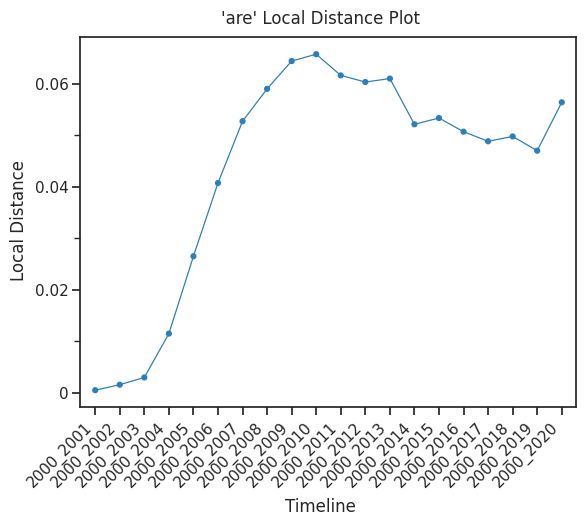

<ggplot: (-9223363265114893494)>

In [11]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/are_time_plot.png


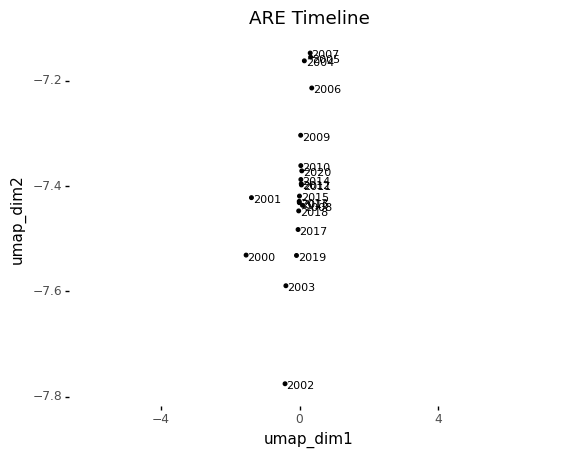

<ggplot: (8771581300330)>


In [12]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/are_time_plot.png")
print(g)

In [13]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots_2000_2020/are.gif"
)

![are gif here](output/wordcloud_plots_2000_2020/are.gif)

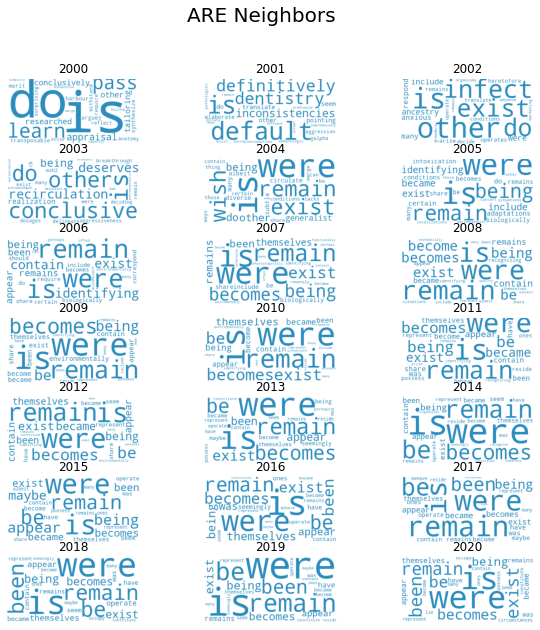

In [14]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots_2000_2020/are.png"
)

## Expression

In [15]:
token_timeline_df = generate_timeline(year_comparison_dict, "expression")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
5468,expression,0.284309,0.029281,0.255027,2000_2018
5468,expression,0.206210,0.008171,0.198038,2000_2004
5468,expression,0.316347,0.036026,0.280321,2000_2013
5468,expression,0.293155,0.033585,0.259570,2000_2017
5468,expression,0.023728,0.000170,0.023558,2000_2001


In [16]:
token_timeline_low_dim_df = project_token_timeline(
    "expression", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,-4.202278,0.731921,2020,expression,main
26,-4.263006,0.836761,2019,expression,main
52,-4.157962,0.743170,2018,expression,main
78,-4.221158,1.040772,2017,expression,main
104,-4.135365,1.082569,2016,expression,main
130,-4.177586,0.956335,2015,expression,main
156,-4.213844,1.072493,2014,expression,main
182,-3.953408,0.986406,2013,expression,main
208,-3.942950,0.824740,2012,expression,main
234,-3.764821,0.635947,2011,expression,main


In [17]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, "expression"
)

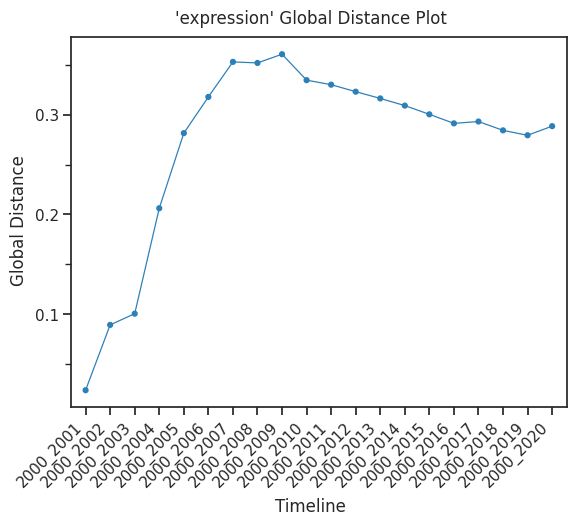

<ggplot: (-9223363265275956406)>

In [18]:
global_distance

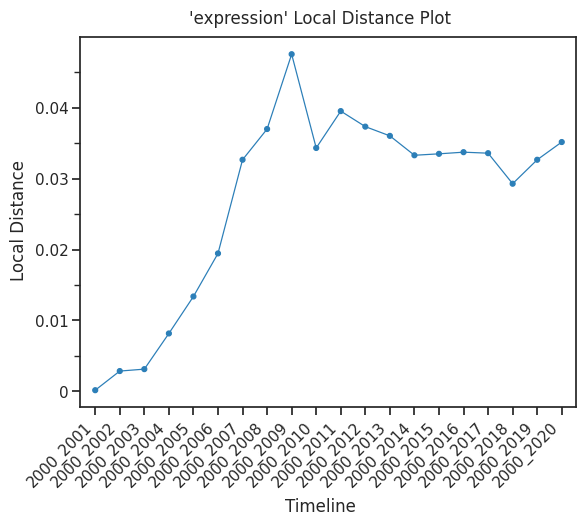

<ggplot: (-9223363265114841179)>

In [19]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/expression_time_plot.png


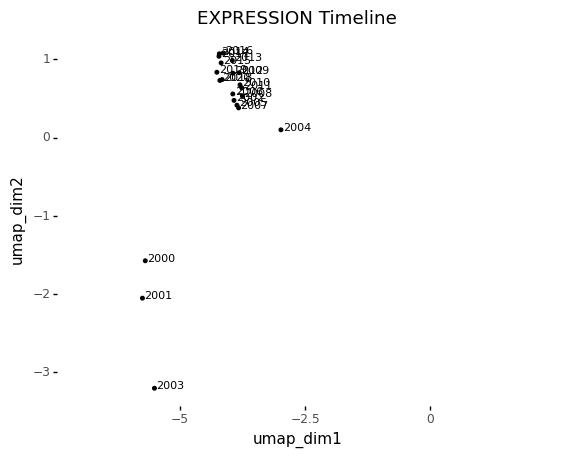

<ggplot: (8771739341432)>


In [20]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/expression_time_plot.png")
print(g)

In [21]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/expression.gif",
)

![expression gif here](output/wordcloud_plots_2000_2020/expression.gif)

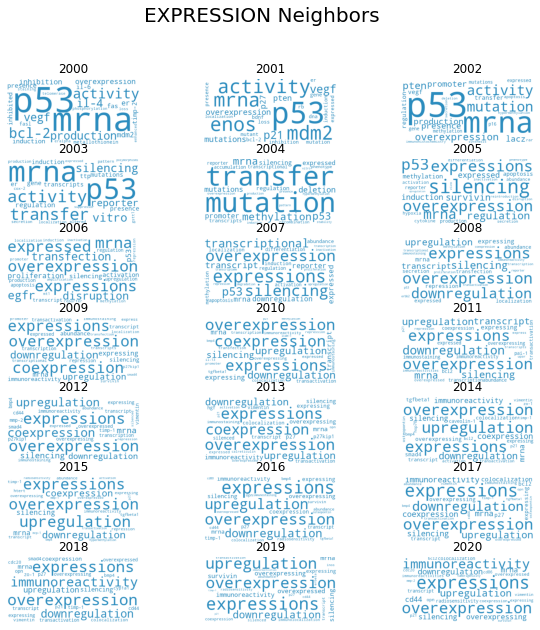

In [22]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/expression.png",
)

## 95%ci

In [23]:
token_timeline_df = generate_timeline(year_comparison_dict, "95%ci")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
1013,95%ci,0.599329,0.195600,0.403728,2000_2018
1013,95%ci,0.116594,0.002625,0.113969,2000_2004
1013,95%ci,0.553756,0.168169,0.385587,2000_2013
1013,95%ci,0.594697,0.187286,0.407411,2000_2017
1013,95%ci,0.212185,0.006686,0.205499,2000_2001


In [24]:
token_timeline_low_dim_df = project_token_timeline(
    "95%ci", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,-1.561079,7.474287,2020,95%ci,main
26,-1.524885,7.486738,2019,95%ci,main
52,-1.396517,7.205892,2018,95%ci,main
78,-1.607168,7.888726,2017,95%ci,main
104,-1.636992,7.520703,2016,95%ci,main
130,-1.575961,7.625524,2015,95%ci,main
156,-1.634357,7.633255,2014,95%ci,main
182,-1.794362,7.700427,2013,95%ci,main
208,-1.669649,7.779773,2012,95%ci,main
234,-1.743619,7.599196,2011,95%ci,main


In [25]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="95%ci"
)

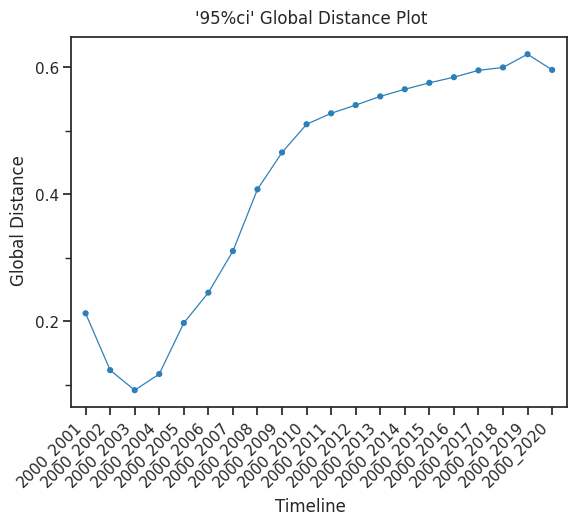

<ggplot: (8771623911565)>

In [26]:
global_distance

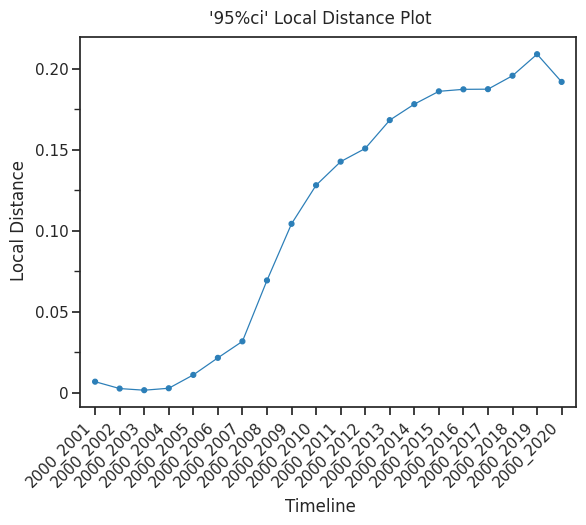

<ggplot: (-9223363265230864177)>

In [27]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/95_ci_time_plot.png


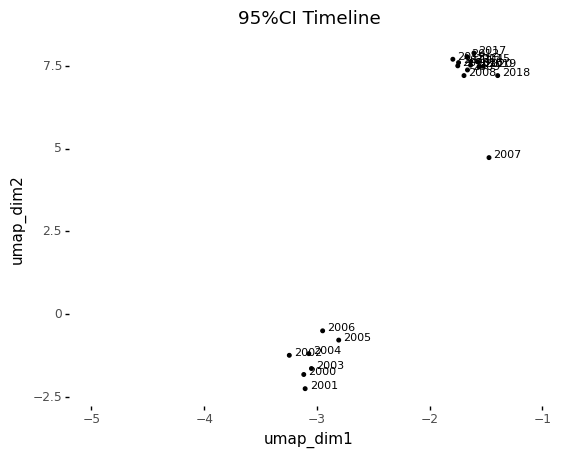

<ggplot: (8771578850501)>


In [28]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/95_ci_time_plot.png")
print(g)

In [29]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/95%ci.gif",
)

![95%ci gif here](output/wordcloud_plots_2000_2020/95%ci.gif)

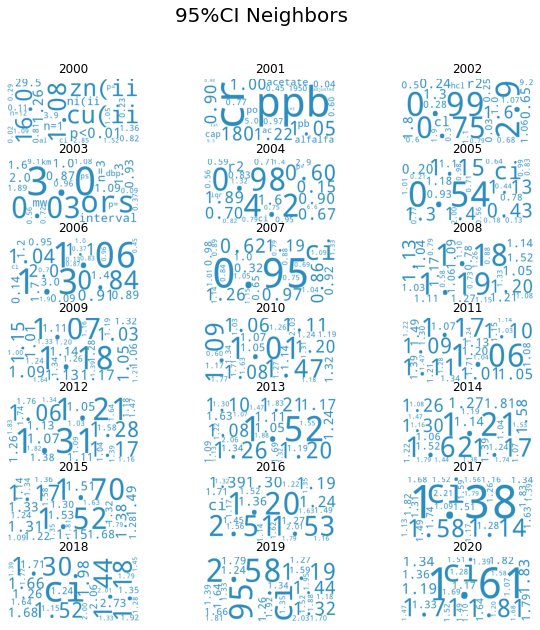

In [30]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/95%ci.png",
)

## interleukin-18

In [31]:
token_timeline_df = generate_timeline(year_comparison_dict, "interleukin-18")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
7355,interleukin-18,0.712403,0.297637,0.414766,2000_2018
7355,interleukin-18,0.448519,0.029837,0.418683,2000_2004
7355,interleukin-18,0.665351,0.283952,0.381399,2000_2013
7355,interleukin-18,0.700358,0.300548,0.399810,2000_2017
7355,interleukin-18,0.213156,0.009061,0.204095,2000_2001


In [32]:
token_timeline_low_dim_df = project_token_timeline(
    "interleukin-18", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,-4.332070,3.224994,2020,interleukin-18,main
26,-4.153968,3.464779,2019,interleukin-18,main
52,-4.190934,3.445966,2018,interleukin-18,main
78,-4.204867,3.484227,2017,interleukin-18,main
104,-4.144827,3.475860,2016,interleukin-18,main
130,-4.296650,3.354359,2015,interleukin-18,main
156,-4.160235,3.525280,2014,interleukin-18,main
182,-4.165676,3.318523,2013,interleukin-18,main
208,-4.039629,3.159667,2012,interleukin-18,main
234,-4.248718,3.249502,2011,interleukin-18,main


In [33]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="interleukin-18"
)

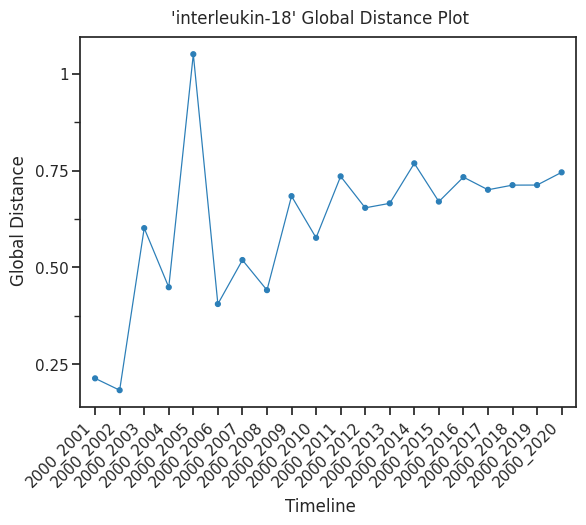

<ggplot: (8771586449377)>

In [34]:
global_distance

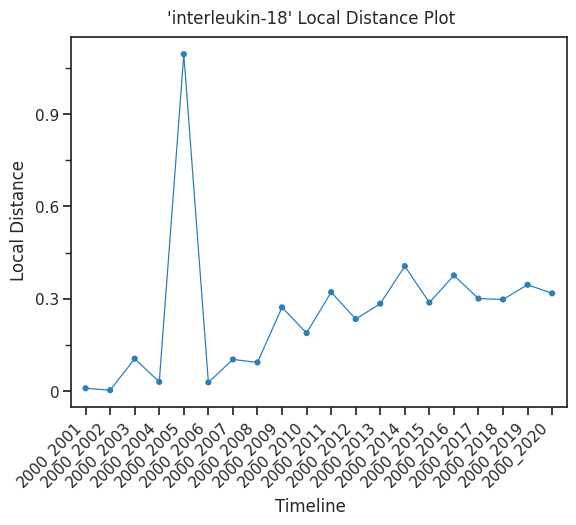

<ggplot: (8771586449384)>

In [35]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/interleukin18_time_plot.png


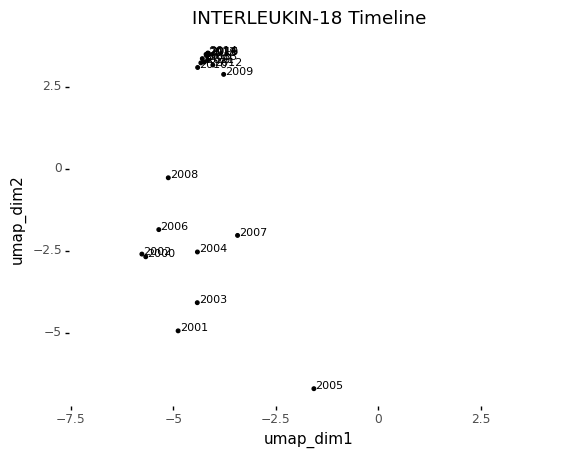

<ggplot: (-9223363265115147460)>


In [36]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/interleukin18_time_plot.png")
print(g)

In [37]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/interleukin-18.gif",
)

![interleukin-18 gif here](output/wordcloud_plots_2000_2020/interleukin-18.gif)

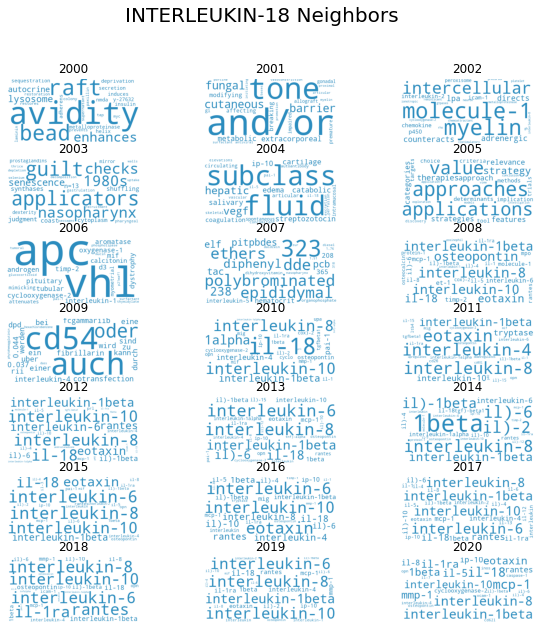

In [38]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/interleukin_18.png",
)

## p53

In [39]:
token_timeline_df = generate_timeline(year_comparison_dict, "p53")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
9680,p53,0.424558,0.060400,0.364159,2000_2018
9680,p53,0.089163,0.002967,0.086196,2000_2004
9680,p53,0.442897,0.068809,0.374089,2000_2013
9680,p53,0.437705,0.068598,0.369107,2000_2017
9680,p53,0.030020,0.000651,0.029369,2000_2001


In [40]:
token_timeline_low_dim_df = project_token_timeline(
    "p53", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,-4.736239,2.263111,2020,p53,main
26,-4.851551,2.255556,2019,p53,main
52,-4.975148,2.234889,2018,p53,main
78,-4.876954,2.144891,2017,p53,main
104,-4.703125,2.216661,2016,p53,main
130,-4.670035,2.244526,2015,p53,main
156,-4.790570,2.207652,2014,p53,main
182,-4.787442,2.194781,2013,p53,main
208,-4.315369,2.251980,2012,p53,main
234,-4.477321,2.105827,2011,p53,main


In [41]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="p53"
)

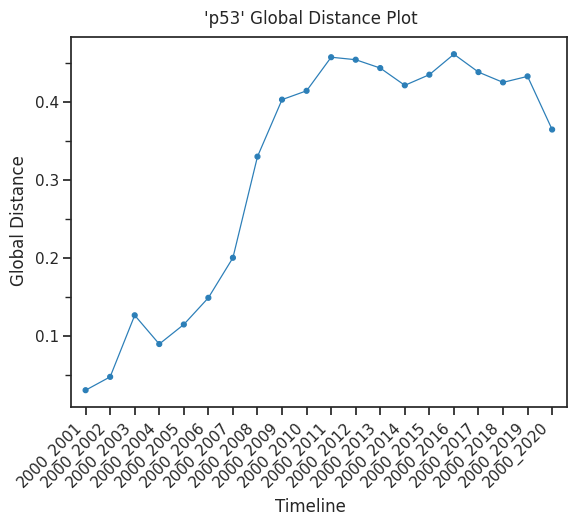

<ggplot: (8771623885695)>

In [42]:
global_distance

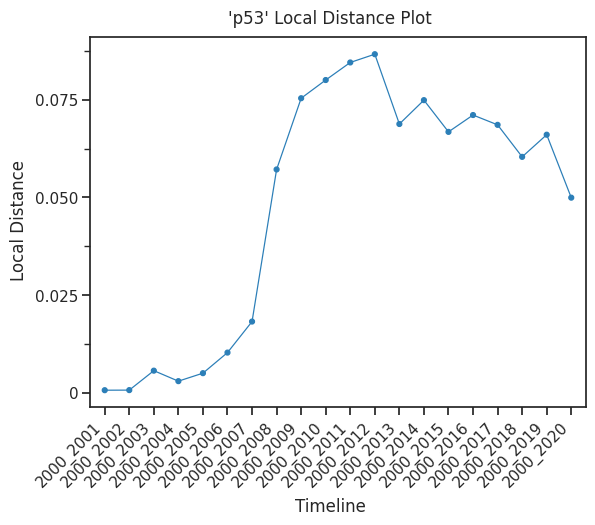

<ggplot: (8771623875199)>

In [43]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/p53_time_plot.png


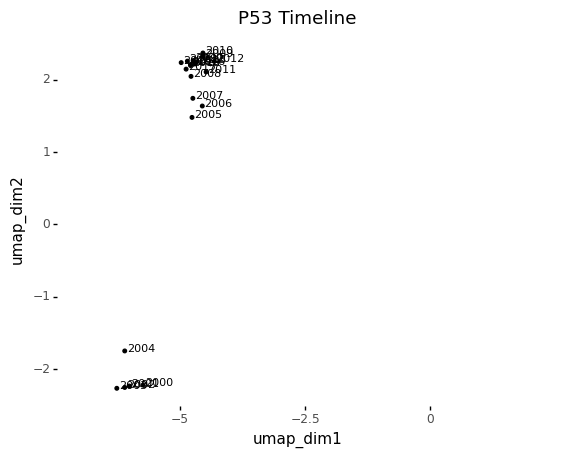

<ggplot: (8771623885576)>


In [44]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/p53_time_plot.png")
print(g)

In [45]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots_2000_2020/p53.gif"
)

![p53 gif here](output/wordcloud_plots_2000_2020/p53.gif)

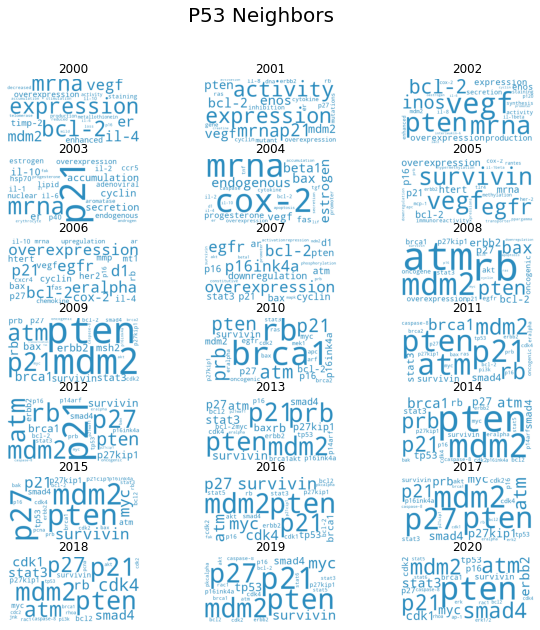

In [46]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots_2000_2020/p53.png"
)

## Cystic

In [47]:
token_timeline_df = generate_timeline(year_comparison_dict, "cystic")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
3953,cystic,0.764235,0.377849,0.386386,2000_2018
3953,cystic,0.185801,0.009424,0.176377,2000_2004
3953,cystic,0.742298,0.392921,0.349377,2000_2013
3953,cystic,0.757458,0.408140,0.349317,2000_2017
3953,cystic,0.047848,0.000419,0.047429,2000_2001


In [48]:
token_timeline_low_dim_df = project_token_timeline(
    "cystic", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,3.062322,1.366387,2020,cystic,main
26,2.983837,1.329151,2019,cystic,main
52,3.022353,1.321075,2018,cystic,main
78,3.022378,1.253935,2017,cystic,main
104,3.046689,1.368189,2016,cystic,main
130,2.930717,1.315106,2015,cystic,main
156,3.001523,1.256890,2014,cystic,main
182,2.896832,1.392852,2013,cystic,main
208,3.103659,1.283698,2012,cystic,main
234,3.060761,1.418566,2011,cystic,main


In [49]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="cystic"
)

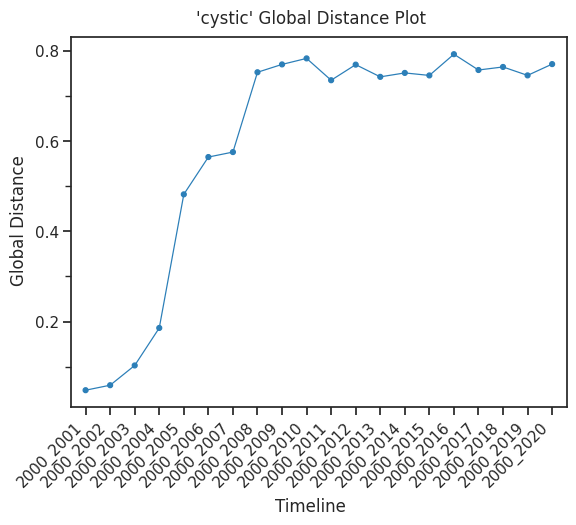

<ggplot: (-9223363265115587552)>

In [50]:
global_distance

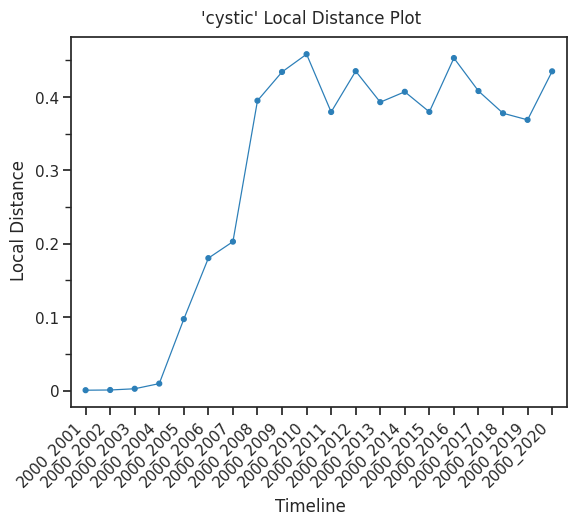

<ggplot: (-9223363265231216212)>

In [51]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/cystic_time_plot.png


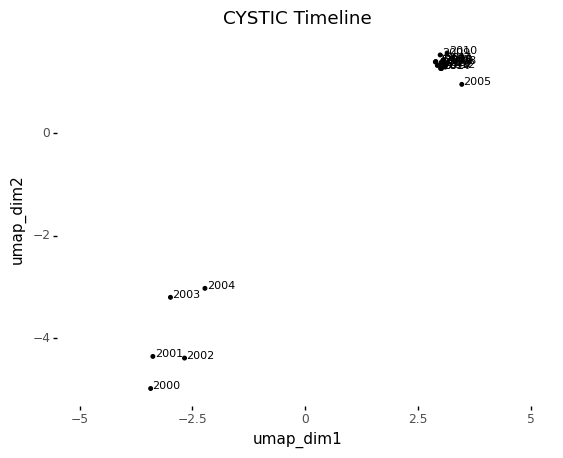

<ggplot: (-9223363265115587503)>


In [52]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/cystic_time_plot.png")
print(g)

In [53]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/cystic.gif",
)

![cystic_gif here](output/wordcloud_plots_2000_2020/cystic.gif)

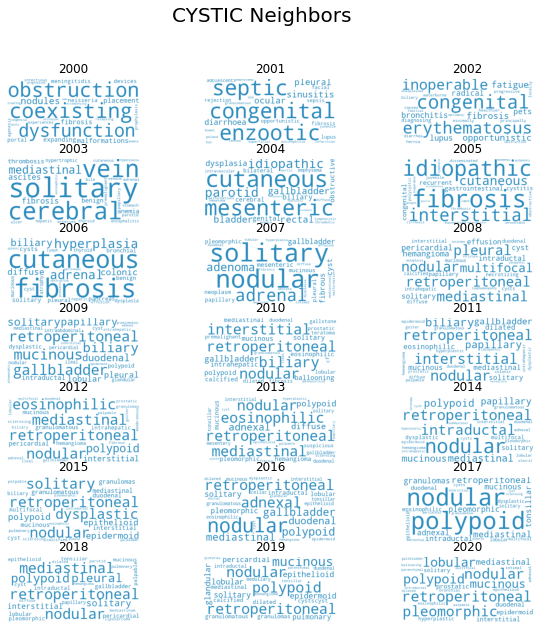

In [54]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/cystic.png",
)

## Cell

In [55]:
token_timeline_df = generate_timeline(year_comparison_dict, "cell")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
2855,cell,0.208242,0.013288,0.194955,2000_2018
2855,cell,0.123987,0.002371,0.121617,2000_2004
2855,cell,0.222159,0.016115,0.206044,2000_2013
2855,cell,0.207875,0.012250,0.195626,2000_2017
2855,cell,0.042841,0.000265,0.042576,2000_2001


In [56]:
token_timeline_low_dim_df = project_token_timeline(
    "cell", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,0.393590,2.360481,2020,cell,main
26,0.523930,2.418171,2019,cell,main
52,0.357573,2.335977,2018,cell,main
78,0.430628,2.405400,2017,cell,main
104,0.418756,2.344516,2016,cell,main
130,0.483337,2.342642,2015,cell,main
156,0.369193,2.389805,2014,cell,main
182,0.415176,2.386427,2013,cell,main
208,0.344309,2.339230,2012,cell,main
234,0.430416,2.314815,2011,cell,main


In [57]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="cell"
)

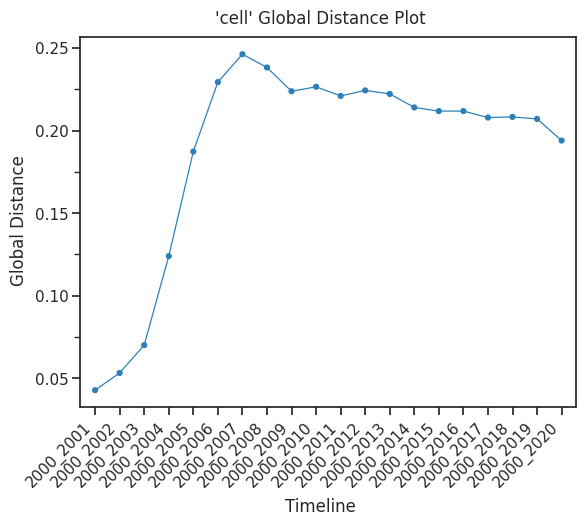

<ggplot: (-9223363265115477118)>

In [58]:
global_distance

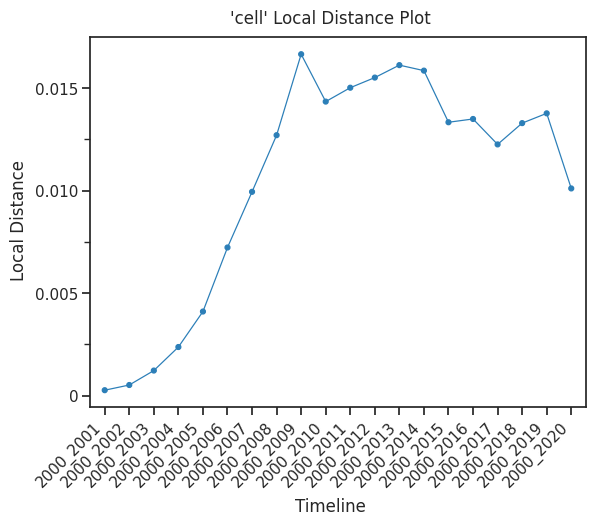

<ggplot: (8771578558419)>

In [59]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/celltime_plot.png


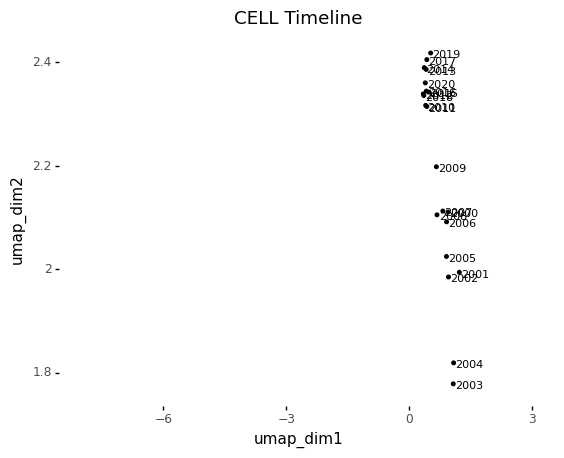

<ggplot: (8771740085007)>


In [60]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/celltime_plot.png")
print(g)

In [61]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots_2000_2020/cell.gif"
)

![cell gif here](output/wordcloud_plots_2000_2020/cell.gif)

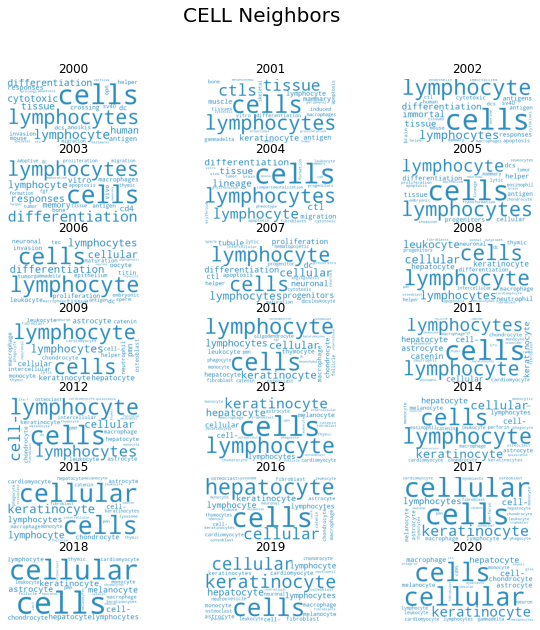

In [62]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots_2000_2020/cell.png"
)

# Conclusions - Take Home Point(s)

1. Aligning vectors helps tremendously when measuring how words change their semantic meaning. Interesting spikes in the distance is words such as cystic, interleukin-18 and like 95%ci.
2. Plotting word clouds for the neighbor of each word highlights the shift these vectors are capturing
3. SpaCy likes to break hyphened words apart which makes capturing words such as RNA-seq and single-cell impossible to detect. Will need to update that if I want to have those words incorporated. Plus I need to use named entity recognition (NER tagger) to group nouns together as a high portion of biological terms are two words and not one.